<a href="https://colab.research.google.com/github/shehara123/asteroid/blob/main/smote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sameepvani/nasa-nearest-earth-objects
! unzip nasa-nearest-earth-objects

  0% 0.00/6.60M [00:00<?, ?B/s]
100% 6.60M/6.60M [00:00<00:00, 71.7MB/s]
Archive:  nasa-nearest-earth-objects.zip
  inflating: neo.csv                 
  inflating: neo_v2.csv              


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
df = pd.read_csv("neo.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [ ]:
dt = df.drop(['id','name','orbiting_body','sentry_object'],axis=1)
dt.shape

(90836, 6)

In [ ]:
training_data = dt.sample(frac=0.8, random_state=25)
testing_data = dt.drop(training_data.index)

In [ ]:
nw_train = training_data.loc[training_data['absolute_magnitude'] <=22.5 ]
nw_test = testing_data.loc[testing_data['absolute_magnitude'] <= 22.5]
print(nw_train.shape,nw_test.shape)

(27078, 6) (6772, 6)


In [ ]:
x_train = nw_train.drop(labels="hazardous", axis =1)
y_train = nw_train['hazardous']
x_test = nw_test.drop(labels="hazardous", axis =1)
y_test = nw_test['hazardous']

In [ ]:
pred =[]
for x in x_train['absolute_magnitude']:
  a = (63987799.135930546/x**6.035718866538284)-0.2033096901714229
  pred.append(a)

mean_squared_error(x_train['est_diameter_max'],pred)

0.024522231862121716

In [ ]:
predy =[]
for x in x_test['absolute_magnitude']:
  a = (63987799.135930546/x**6.035718866538284)-0.2033096901714229
  predy.append(a)
mean_squared_error(x_test['est_diameter_max'],predy)

0.019361697209793853

In [ ]:
x_train = x_train.drop(['est_diameter_max','est_diameter_min'],axis = 1)
x_test = x_test.drop(['est_diameter_max','est_diameter_min'],axis = 1)

In [ ]:
x_train['est_diameter_max'] = pred
x_test['est_diameter_max'] = predy

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(x_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({False: 20026, True: 7052})
Resample dataset shape Counter({False: 20026, True: 20026})


In [ ]:
x_smote.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
0,0.175612,0.485446,97336.007775,6.230191e+07,20.90
1,0.350393,0.876353,39888.653037,4.916702e+07,19.40
2,0.366906,0.910561,104330.738125,7.335124e+07,19.30
3,0.140785,0.397234,59630.403597,4.586530e+07,21.38
4,0.319562,0.811543,83656.256012,3.059910e+06,19.60


In [ ]:
type(x_train.iloc[0,:1])

pandas.core.series.Series

In [ ]:
x_train.loc[0,:1]

est_diameter_min    0.175612
Name: 24363, dtype: float64

In [ ]:
#standardization 
from sklearn.preprocessing import StandardScaler
sclar = StandardScaler()

x_train = pd.DataFrame(sclar.fit_transform(x_smote) ,columns = x_smote.columns)
x_train.head()

,relative_velocity,miss_distance,absolute_magnitude,est_diameter_max
0,1.422298,0.968819,0.351813,-0.266642
1,-0.749237,0.305410,-0.733609,0.190170
2,1.686701,1.526893,-0.805970,0.230145
3,-0.002990,0.138648,0.699148,-0.369726
4,0.905197,-2.023342,-0.588886,0.114433


In [ ]:
x_test = pd.DataFrame(sclar.transform(x_test) ,columns = x_test.columns)
x_test.head()

,relative_velocity,miss_distance,absolute_magnitude,est_diameter_max
0,1.885661,1.267351,0.747767,-0.383193
1,-0.546108,1.074412,0.161531,-0.202743
2,0.069636,-1.159688,0.060206,-0.166244
3,-0.539862,0.717326,0.422080,-0.289003
4,-1.017460,1.448934,0.422080,-0.289003


In [ ]:
y_train = y_smote

model building

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {"penalty":["none","l1","l2","elasticnet"],
          "C": np.logspace(-5,5,20),
          "solver":["liblinear","sag","saga","lbfgs","newton-cg"],
          "max_iter": [10,100,1000,10000,100000]
    }
model = LogisticRegression(random_state=0)
clf = GridSearchCV(model, param_grid = params, cv = 5, n_jobs=-1)
clf.fit(x_train,y_train)
best_params = clf.best_params_
best_model = LogisticRegression(**best_params)
best_model.fit(x_train, y_train)

In [ ]:
#logistic model performance 
log_pred = best_model.predict(x_train)
test_pred = best_model.predict(x_test)

#confusion_matrix = metrics.confusion_matrix(y_train, log_pred)
print("accuracy of logistic on train",metrics.accuracy_score(y_train, log_pred))
print("accuracy of logistic on train",metrics.accuracy_score(y_test, test_pred))

accuracy of logistic on train 0.5879356836113053
accuracy of logistic on train 0.5956881275841701


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Calculating errors
train_error= []
test_error= []

for k in range(1, 10):
    knn= KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)

    y_pred1= knn.predict(x_train)
    train_error.append(np.mean(y_train!=y_pred1))

    y_pred2= knn.predict(x_test)
    test_error.append(np.mean(y_test!=y_pred2))

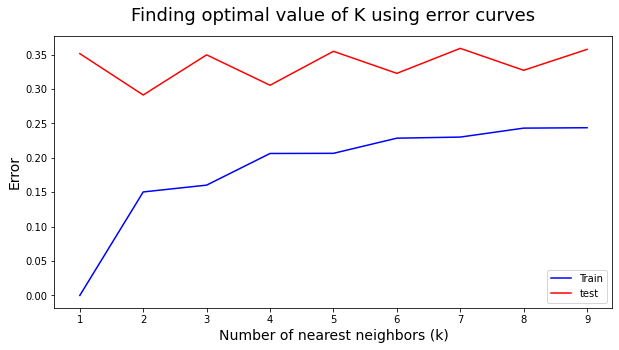

In [ ]:
# Plotting error curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), train_error, color='b', label="Train")
plt.plot(range(1, 10), test_error, color='r', label="test")
plt.xlabel('Number of nearest neighbors (k)', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Finding optimal value of K using error curves', fontsize=18, pad=15)
plt.legend()
plt.show()

In [ ]:
# Instantiate the KNN class 
knn= KNeighborsClassifier(n_neighbors=3)

# Fitting the data
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#knn model performance 
knn_pred = knn.predict(x_train)
knn_valid = knn.predict(x_test)
#confusion_matrix = metrics.confusion_matrix(y_train, log_pred)
print("accuracy of knn on train",metrics.accuracy_score(y_train, knn_pred))
print("accuracy of knn on validation",metrics.accuracy_score(y_test, knn_valid))

accuracy of knn on train 0.8396584440227703
accuracy of knn on validation 0.6503248670998228


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#find best solver

# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


Mean Accuracy: 0.582
Config: {'solver': 'svd'}


In [ ]:
#selecting best shrinkage
from numpy import arange
# define model
model = LinearDiscriminantAnalysis(solver='lsqr')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(x_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.582
Config: {'shrinkage': 0.0}


In [ ]:
metrics.accuracy_score(y_test,results.predict(x_test))

0.5919964559952746

QDA

In [ ]:
#Fit the QDA model
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

model = QuadraticDiscriminantAnalysis()
model.fit(x_train, y_train)

QuadraticDiscriminantAnalysis()

In [ ]:
#QDA model performance 
qda_pred = model.predict(x_train)
qda_valid = model.predict(x_test)
#confusion_matrix = metrics.confusion_matrix(y_train, log_pred)
print("accuracy of QDA on train",metrics.accuracy_score(y_train, qda_pred))
print("accuracy of QDA on validation",metrics.accuracy_score(y_test, qda_valid))

accuracy of QDA on train 0.5609957055827425
accuracy of QDA on validation 0.36606615475487303


random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
rf_train_pred = rf.predict(x_train)
rf_test_pred = rf.predict(x_test)
print("accuracy of rf on train",metrics.accuracy_score(y_train, rf_train_pred))
print("accuracy of rf on test",metrics.accuracy_score(y_test, rf_test_pred))

accuracy of rf on train 1.0
accuracy of rf on test 0.7601890135853514


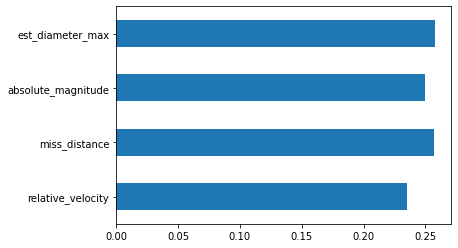

In [ ]:
(pd.Series(rf.feature_importances_, index=x_train.columns).plot(kind='barh'))

# SVC

In [ ]:
from sklearn import svm
clf = svm.SVC()
svc_model = clf.fit(x_train,y_train)

In [ ]:
train_pred = svc_model.predict(x_train)
test_pred = svc_model.predict(x_test)
print("accuracy of rf on train",metrics.accuracy_score(y_train, train_pred))
print("accuracy of rf on test",metrics.accuracy_score(y_test, test_pred))

accuracy of rf on train 0.6908269249975032
accuracy of rf on test 0.6315711754282339


HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
HGB = HistGradientBoostingClassifier().fit(x_train,y_train)

In [ ]:
HGB_train_pred = HGB.predict(x_train)
HGB_test_pred = HGB.predict(x_test)
print("accuracy of rf on train",metrics.accuracy_score(y_train, HGB_train_pred))
print("accuracy of rf on test",metrics.accuracy_score(y_test, HGB_test_pred))

accuracy of rf on train 0.8102966144012783
accuracy of rf on test 0.7306556408741879


Adaboosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier().fit(x_train,y_train)

In [ ]:
train_pred = ada.predict(x_train)
test_pred = ada.predict(x_test)
print("accuracy of rf on train",metrics.accuracy_score(y_train, train_pred))
print("accuracy of rf on test",metrics.accuracy_score(y_test, test_pred))

accuracy of rf on train 0.6698541895535803
accuracy of rf on test 0.6101594802126403


,('svc',svc_model)

In [ ]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(estimators=[('lr',best_model),('knn',knn),('rf',rf),('HGB',HGB),('ada',ada)],
                          voting='hard')

In [ ]:
#voting classifier training
voting.fit(x_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=6.1584821106602545,
                                                 penalty='l1', solver='saga')),
                             ('knn', KNeighborsClassifier(n_neighbors=3)),
                             ('rf', RandomForestClassifier()),
                             ('HGB', HistGradientBoostingClassifier()),
                             ('ada', AdaBoostClassifier())])

In [ ]:
train_pred = voting.predict(x_train)
test_pred = voting.predict(x_test)
print("accuracy of voting on train",metrics.accuracy_score(y_train, train_pred))
print("accuracy of voting on test",metrics.accuracy_score(y_test, test_pred))

accuracy of voting on train 0.8784330370518326
accuracy of voting on test 0.7181039574719433


further exploration on RF and highgradiant boosting

In [ ]:
rf_cm = confusion_matrix(y_test, rf_test_pred)

# Assigning columns names
cm_df = pd.DataFrame(rf_cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,4229,755
Actual Positive,869,919


In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(rf_cm)

True Positives: 919
True Negatives: 4229
False Positives: 755
False Negatives: 869
--------------------------------------------------
Accuracy: 0.76
Mis-Classification: 0.24
Sensitivity: 0.51
Specificity: 0.85
Precision: 0.85
f_1 Score: 0.64


## HGB

In [ ]:
HGB_cm = confusion_matrix(y_test, rf_test_pred)

# Assigning columns names
cm_df = pd.DataFrame(HGB_cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,4229,755
Actual Positive,869,919


In [ ]:
confusion_metrics(HGB_cm)

True Positives: 919
True Negatives: 4229
False Positives: 755
False Negatives: 869
--------------------------------------------------
Accuracy: 0.76
Mis-Classification: 0.24
Sensitivity: 0.51
Specificity: 0.85
Precision: 0.85
f_1 Score: 0.64


VIP of RF

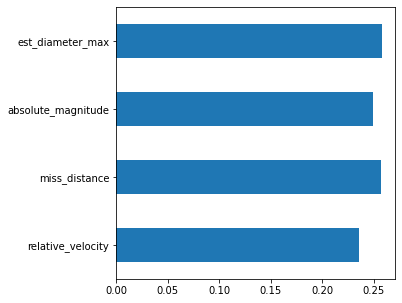

In [ ]:
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(5)
(pd.Series(rf.feature_importances_, index=x_train.columns).plot(kind='barh'))
plt.show()

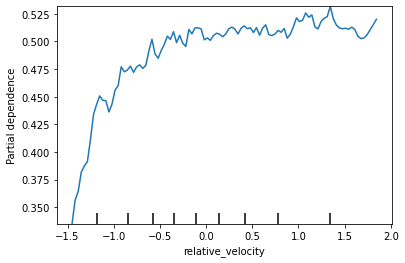

In [ ]:
PartialDependenceDisplay.from_estimator(rf, x_train, [0], target='False')

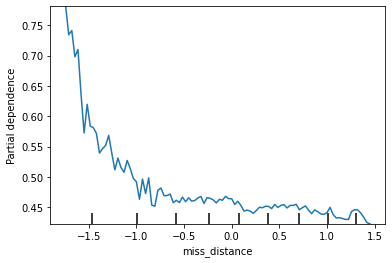

In [ ]:
PartialDependenceDisplay.from_estimator(rf, x_train, [1], target='False')

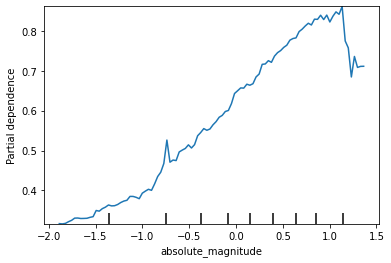

In [ ]:
PartialDependenceDisplay.from_estimator(rf, x_train, [2], target='False')

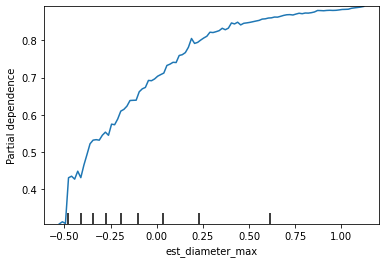

In [ ]:
PartialDependenceDisplay.from_estimator(rf, x_train, [3], target='False')

In [ ]:
import pickle
# # create an iterator object with write permission - model.pickle
# with open('RF_model', 'wb') as files:
#     pickle.dump(rf, files)

In [ ]:
with open('stand_scale', 'wb') as files:
    pickle.dump(sclar, files)

In [ ]:
dt = x_train.iloc[0:1,:]

In [ ]:
dt.head()

,relative_velocity,miss_distance,absolute_magnitude,est_diameter_max
0,1.422298,0.968819,0.351813,-0.266642


In [ ]:
rf.predict(dt)

array([False])

In [ ]:
dt[['absolute_magnitude']]= 4

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = value


In [ ]:
dt.to_pickle("tbl.pkl")

In [ ]:
pip install --upgrade pandas==1.3.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 2.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
